# Genome-scale characterizing of RNA export bias

# Introduction

## Imports

In [1]:
import sys
import os
import time

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Set output parameters

In [2]:
# Set pandas display options
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Set plot display options
FONTSIZE = 8  # universal fontsize
params = {
    'font.size': FONTSIZE,
    'axes.titlesize': FONTSIZE,
    'axes.labelsize': FONTSIZE,
    'legend.fontsize': FONTSIZE,
    'xtick.labelsize': FONTSIZE,
    'ytick.labelsize': FONTSIZE,
    'font.family': "Helvetica",
    'mathtext.fontset': 'custom',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }
mpl.rcParams.update(params)
sns.set_style("ticks", {'axes.grid' : False})

# Set plot output options
output_dir = "outs/transcriptome_bias"
output_suffix = ""
output_formats = [".png", ".pdf"]

mpl.rc('savefig', dpi=300)

# Define convenience function for saving figures

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.1}

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

In [3]:
# Report plot parameters
sns.plotting_context()

{'font.size': 8.0,
 'axes.labelsize': 8.0,
 'axes.titlesize': 8.0,
 'xtick.labelsize': 8.0,
 'ytick.labelsize': 8.0,
 'legend.fontsize': 8.0,
 'legend.title_fontsize': None,
 'axes.linewidth': 0.8,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.8,
 'ytick.major.width': 0.8,
 'xtick.minor.width': 0.6,
 'ytick.minor.width': 0.6,
 'xtick.major.size': 3.5,
 'ytick.major.size': 3.5,
 'xtick.minor.size': 2.0,
 'ytick.minor.size': 2.0}

# Load data

## Load read counts

In [4]:
# Load read counts from supernatant

infile = "../preprocessed_data/transcriptome_data/transcriptomics_supernatant/htseq.tab"

counts_raw = pd.read_csv(infile, sep="\t", header=0, index_col=0)

print(counts_raw.shape)
counts_raw.head()

(60766, 8)


,sFH14_1,sFH14_2,sFH14_3,sFH14_4,sFH14_5,sFH14_6,sFH14_7,sFH14_8
symbol,,,,,,,,
EGFP,60400,821,1067,12295,0,0,0,0
ENSG00000000003,6759,3981,52,83,26,41,23,14
ENSG00000000005,7,0,0,0,0,0,0,0
ENSG00000000419,819,296,0,74,14,15,13,21
ENSG00000000457,96,0,21,10,5,0,0,23


In [5]:
# Load read counts from cells

infile = "../preprocessed_data/transcriptome_data/transcriptomics_cell/htseq.tab"

counts_cells_raw = pd.read_csv(infile, sep="\t", header=0, index_col=0)

print(counts_cells_raw.shape)
counts_cells_raw.head()

(60766, 8)


,L220420_1,L220420_2,L220420_3,L220420_4,L220420_5,L220420_6,L220420_7,L220420_8
symbol,,,,,,,,
EGFP,198592,98788,93438,62364,0,0,0,0
ENSG00000000003,2691,2615,2802,2800,2464,3358,3184,2991
ENSG00000000005,7,2,8,7,5,8,10,11
ENSG00000000419,1514,1543,1533,1536,1263,1936,1291,1139
ENSG00000000457,535,614,653,625,522,686,614,557


## Load additional resources

In [6]:
# Load ERCC gene names

infile = "../resources/names_ERCC92.txt"

names_ERCC = []
with open(infile) as f:
    for line in f:
        names_ERCC.append(line.rstrip())
print("Loaded", len(names_ERCC), "gene names")

Loaded 92 gene names


## Specify sample information (names, colors)

In [7]:
# Set transgene names
names_transgenes = ["EGFP", "mCherry", "mTagBFP2"]

In [8]:
# Set exporter labels
sample_to_exporter = {"sFH14_1": "MMLV Gag",
                   "sFH14_2": "Gag-MCP",
                   "sFH14_3": "GagZip-MCP",
                   "sFH14_4": "EPN24-MCP",
                   "sFH14_5": "No exporter (mCh-Psi)",
                   "sFH14_6": "No exporter (mCh-MS2x8)",
                   "sFH14_7": "No DNA",
                   "sFH14_8": "WT"}

# Preprocess data from cells

## Rename samples to same labels as supernatant samples

In [9]:
columns_cells_to_supernatant = {"L220420_1": "sFH14_1",
                                "L220420_2": "sFH14_2",
                                "L220420_3": "sFH14_3",
                                "L220420_4": "sFH14_4",
                                "L220420_5": "sFH14_5",
                                "L220420_6": "sFH14_6",
                                "L220420_7": "sFH14_7",
                                "L220420_8": "sFH14_8"}

counts_cells_raw = counts_cells_raw.rename(columns_cells_to_supernatant, axis=1)

## Convert gene names from Ensembl to symbol

In [10]:
# Convert gene names from Ensembl to symbols (actually symbol underscore Ensembl ID)
df_ensembleToSymbol = pd.read_csv("../resources/Ensembl_to_symbol.csv", header=0, index_col=0, sep=",")
counts_cells_raw["symbol_ensembl"] = df_ensembleToSymbol.loc[counts_cells_raw.index]["symbol_ensembl"]
counts_cells_raw.set_index("symbol_ensembl", inplace=True)

## Drop genes that are never observed

In [11]:
# Report how many genes are never observed
print(np.sum(counts_cells_raw.sum(axis=1) == 0), "genes are never observed (count = 0 for all samples)")
print(np.mean(counts_cells_raw.sum(axis=1) == 0)*100, "% of genes are never observed (count = 0 for all samples)")

29978 genes are never observed (count = 0 for all samples)
49.33350887009183 % of genes are never observed (count = 0 for all samples)


In [12]:
# Actually drop genes that are not observed

names_unmapped = ['__no_feature', '__ambiguous', '__too_low_aQual', '__not_aligned', '__alignment_not_unique']

# Remove names of special genes that we want to not drop (STAR unmapped reads, ERCCs, transgenes)
names_not_observed = counts_cells_raw.loc[counts_cells_raw.sum(axis=1) == 0].index  # names of genes that were never observed
names_not_observed_clean = list(set(names_not_observed) - set(names_unmapped + names_ERCC + names_transgenes))  # remove names of special genes that we want to keep

counts_cells_raw = counts_cells_raw.drop(names_not_observed_clean)  # drop genes

print(counts_cells_raw.shape)
counts_cells_raw.head()

(30882, 8)


,sFH14_1,sFH14_2,sFH14_3,sFH14_4,sFH14_5,sFH14_6,sFH14_7,sFH14_8
symbol_ensembl,,,,,,,,
EGFP,198592,98788,93438,62364,0,0,0,0
TSPAN6_ENSG00000000003,2691,2615,2802,2800,2464,3358,3184,2991
TNMD_ENSG00000000005,7,2,8,7,5,8,10,11
DPM1_ENSG00000000419,1514,1543,1533,1536,1263,1936,1291,1139
SCYL3_ENSG00000000457,535,614,653,625,522,686,614,557


## Drop ERCCs

In [13]:
counts_cells_raw_NoERCC = counts_cells_raw.drop(names_ERCC)
print(counts_cells_raw_NoERCC.shape)

(30790, 8)


## Normalize to total counts (CPM)

In [14]:
counts_cells_cpm = counts_cells_raw_NoERCC.copy()  # work with a copy of the counts, so we don't touch the raw counts

# Drop symbols for mapping reporting
counts_cells_cpm = counts_cells_cpm.drop(names_unmapped, axis=0)

# Normalize by total read number
counts_cells_cpm = counts_cells_cpm / counts_cells_cpm.sum(axis=0)

# Multiply by 1e6 to get counts per million
counts_cells_cpm = 1e6 * counts_cells_cpm

print(counts_cells_cpm.shape)

(30785, 8)


## Log-transform

In [15]:
# Add pseudocounts and log transform
counts_cells_cpm_log2 = np.log2(counts_cells_cpm + 1)

print(counts_cells_cpm_log2.shape)

(30785, 8)


# Preprocess data from supernatant

## Convert gene names from Ensembl to symbol

In [16]:
# Convert gene names from Ensembl to symbols (actually symbol underscore Ensembl ID)
df_ensembleToSymbol = pd.read_csv("../resources/Ensembl_to_symbol.csv", header=0, index_col=0, sep=",")
counts_raw["symbol_ensembl"] = df_ensembleToSymbol.loc[counts_raw.index]["symbol_ensembl"]
counts_raw.set_index("symbol_ensembl", inplace=True)

## Drop genes that are never observed

In [17]:
# Report how many genes are never observed
print(np.sum(counts_raw.sum(axis=1) == 0), "genes are never observed (count = 0 for all samples)")
print(np.mean(counts_raw.sum(axis=1) == 0)*100, "% of genes are never observed (count = 0 for all samples)")

39519 genes are never observed (count = 0 for all samples)
65.03472336503965 % of genes are never observed (count = 0 for all samples)


In [18]:
# Actually drop genes that are never observed

names_unmapped = ['__no_feature', '__ambiguous', '__too_low_aQual', '__not_aligned', '__alignment_not_unique']

names_not_observed = counts_raw.loc[counts_raw.sum(axis=1) == 0].index  # names of genes that were never observed
names_not_observed_clean = list(set(names_not_observed) - set(names_unmapped + names_ERCC + names_transgenes))  # remove names of special genes that we want to keep

counts_raw = counts_raw.drop(names_not_observed_clean)  # drop genes

print(counts_raw.shape)
counts_raw.head()

(21249, 8)


,sFH14_1,sFH14_2,sFH14_3,sFH14_4,sFH14_5,sFH14_6,sFH14_7,sFH14_8
symbol_ensembl,,,,,,,,
EGFP,60400,821,1067,12295,0,0,0,0
TSPAN6_ENSG00000000003,6759,3981,52,83,26,41,23,14
TNMD_ENSG00000000005,7,0,0,0,0,0,0,0
DPM1_ENSG00000000419,819,296,0,74,14,15,13,21
SCYL3_ENSG00000000457,96,0,21,10,5,0,0,23


## Drop ERCCs

In [19]:
counts_NoERCC = counts_raw.copy()  # work with a copy of the counts, so we don't touch the raw counts

# Drop symbols for ERCCs
counts_NoERCC = counts_NoERCC.drop(names_ERCC, axis=0)

print(counts_NoERCC.shape)

(21157, 8)


## Normalize to total counts (CPM)

In [20]:
counts_cpm = counts_NoERCC.copy()  # work with a copy of the counts, so we don't touch the raw counts

# Drop symbols for mapping reporting
counts_cpm = counts_cpm.drop(names_unmapped, axis=0)

# Normalize by total read number
counts_cpm = counts_cpm / counts_cpm.sum(axis=0)

# Multiply by 1e6 to get counts per million
counts_cpm = 1e6 * counts_cpm

print(counts_cpm.shape)

(21152, 8)


## Log-transform

In [21]:
# Add pseudocounts and log transform
counts_cpm_log2 = np.log2(counts_cpm + 1)

print(counts_cpm_log2.shape)

(21152, 8)


# Transform cell and supernatant data to have matching gene sets

In [22]:
print("Supernatant", counts_cpm_log2.shape)
print("Cells", counts_cells_cpm_log2.shape)

# Cells have more genes detected than supernatant.
# Set index to union of gene sets to ensure that any label is found in both datasets.

Supernatant (21152, 8)
Cells (30785, 8)


In [23]:
names_intersection = list(set(counts_cpm_log2.index).intersection(set(counts_cells_cpm_log2.index)))
n_intersection = len(names_intersection)

print("Intersection", n_intersection)
print("Supernatant only", counts_cpm_log2.shape[0] - n_intersection)
print("Cells only", counts_cells_cpm_log2.shape[0] - n_intersection)

Intersection 20353
Supernatant only 799
Cells only 10432


In [24]:
# Add missing labels to cells

names_supernatant_only = list(set(counts_cpm_log2.index) - set(counts_cells_cpm_log2.index))

counts_cells_cpm_log2_filled = counts_cells_cpm_log2.append(pd.DataFrame(columns=counts_cells_cpm_log2.columns, index=names_supernatant_only))
counts_cells_cpm_log2_filled = counts_cells_cpm_log2_filled.fillna(0)  # fill missing values with zero

print(counts_cells_cpm_log2_filled.shape)

(31584, 8)


In [25]:
# Add missing labels to supernatant

names_cells_only = list(set(counts_cells_cpm_log2.index) - set(counts_cpm_log2.index))

counts_cpm_log2_filled = counts_cpm_log2.append(pd.DataFrame(columns=counts_cpm_log2.columns, index=names_cells_only))
counts_cpm_log2_filled = counts_cpm_log2_filled.fillna(0)  # fill missing values with zero
counts_cpm_log2_filled = counts_cpm_log2_filled.loc[counts_cells_cpm_log2_filled.index]  # sort values to be in the same order as cell dataframe

print(counts_cpm_log2_filled.shape)

(31584, 8)


# Calculate enrichment between supernatant and cells

In [26]:
# Calculate log2 fold-change of supernatant over cells

log2fc = counts_cpm_log2_filled - counts_cells_cpm_log2_filled

log2fc

,sFH14_1,sFH14_2,sFH14_3,sFH14_4,sFH14_5,sFH14_6,sFH14_7,sFH14_8
EGFP,-1.390831,-5.494546,-1.506922,0.306727,0.000000,0.000000,0.000000,0.000000
TSPAN6_ENSG00000000003,1.646048,1.996817,-0.797389,-2.371373,-0.441899,0.055385,-0.388677,-0.754884
TNMD_ENSG00000000005,0.080584,-0.114004,-0.395191,-0.353229,-0.315592,-0.345497,-0.479787,-0.537353
DPM1_ENSG00000000419,-0.549753,-0.959894,-5.939799,-1.673189,-0.368324,-0.589120,0.085371,1.197526
SCYL3_ENSG00000000457,-1.954054,-4.713910,-0.013366,-2.885760,-0.558840,-4.597111,-4.656762,2.328401
...,...,...,...,...,...,...,...,...
ENSG00000248423,0.335988,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FAM205BP_ENSG00000257198,0.274761,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000286171,0.000000,0.000000,0.000000,0.320382,0.000000,0.000000,2.367819,0.000000
RN7SL494P_ENSG00000241175,0.000000,0.000000,0.000000,0.320382,0.000000,0.000000,0.000000,0.000000


In [27]:
# Sort values by highest fold-change in samples with exporter
log2fc = log2fc.loc[log2fc[["sFH14_1", "sFH14_2", "sFH14_3", "sFH14_4"]].mean(axis=1).sort_values(ascending=False).index]

# Plot bias of RNA export (abundance per gene in cell and supernatant RNA)

In [28]:
# Get gene names of mitochondrial-encoded RNA

names_mtRNA = [s  for s in list(counts_cells_cpm_log2_filled.index) if s.startswith("MT-")]

print(len(names_mtRNA), "genes")

for _ in names_mtRNA:
    print(_)

16 genes
MT-ND6_ENSG00000198695
MT-CO2_ENSG00000198712
MT-CYB_ENSG00000198727
MT-ND2_ENSG00000198763
MT-ND5_ENSG00000198786
MT-CO1_ENSG00000198804
MT-ND3_ENSG00000198840
MT-ND4_ENSG00000198886
MT-ND1_ENSG00000198888
MT-ATP6_ENSG00000198899
MT-CO3_ENSG00000198938
MT-RNR2_ENSG00000210082
MT-TY_ENSG00000210144
MT-RNR1_ENSG00000211459
MT-ND4L_ENSG00000212907
MT-ATP8_ENSG00000228253


In [29]:
# Set plotting parameters

# Set gene colors
gene_to_color = {"mCherry": "#db6aa9", "EGFP": "#33a02c", "mTagBFP2": "#969696"}

# Set gene markers
gene_to_marker = {"mCherry": "*", "EGFP": "hexagon2", "mTagBFP2": "o"}

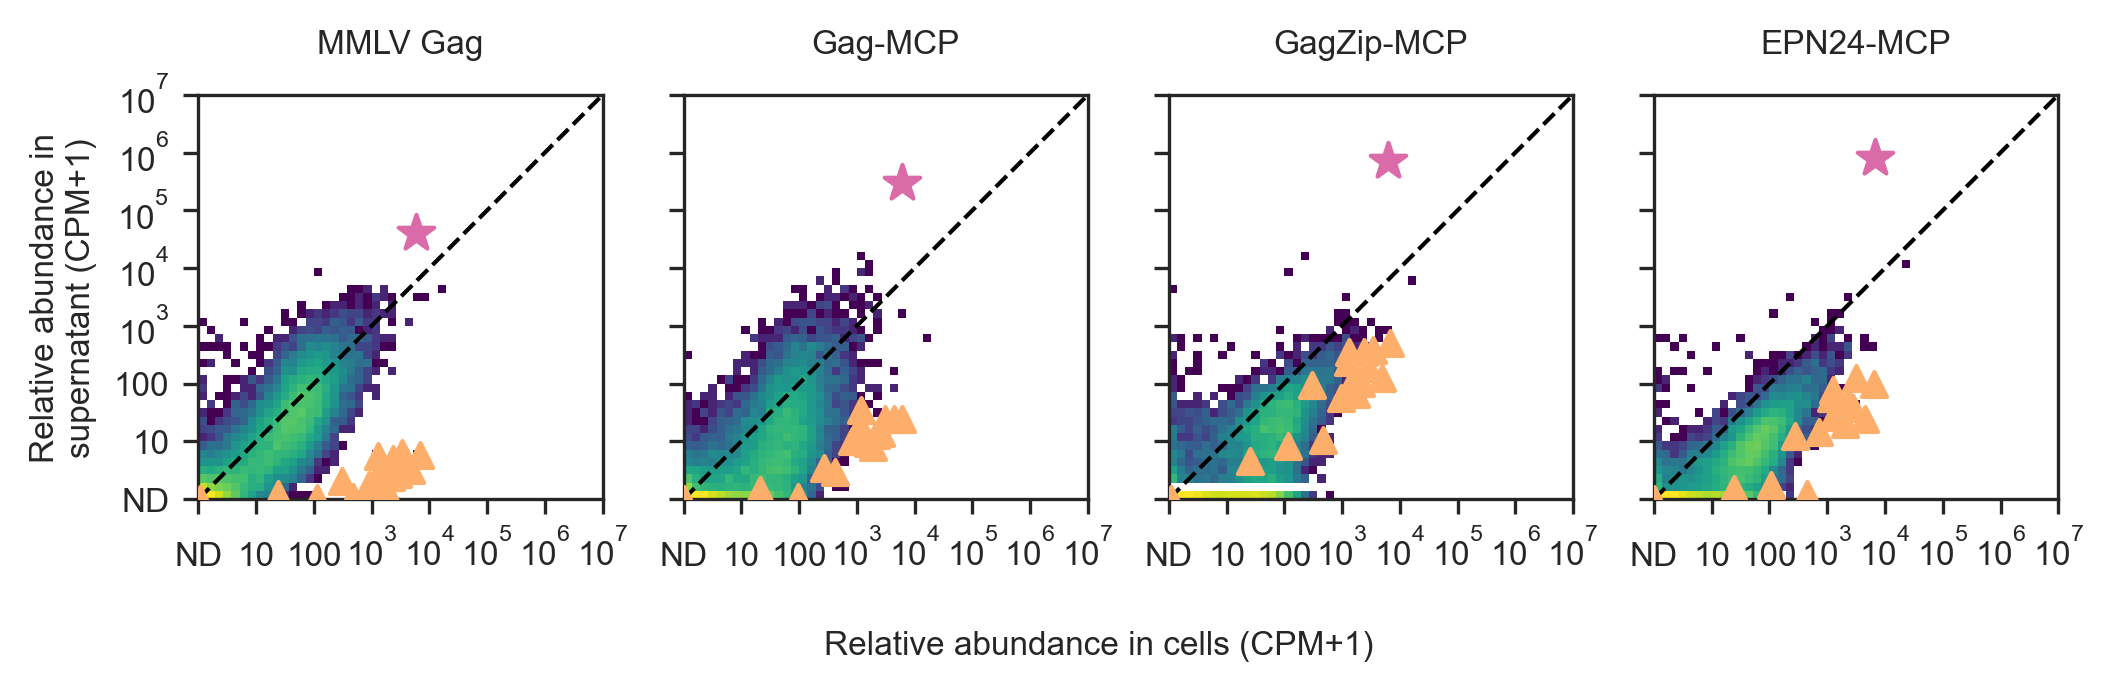

In [30]:
# Plot only exporters

data = counts_cells_cpm_log2_filled[["sFH14_1", "sFH14_2", "sFH14_3", "sFH14_4"]]

fig, axes = plt.subplots(1, 4, figsize=(8,2), sharey=True, sharex=True)

for i, name in enumerate(data.columns):
    
    ax = axes.flatten()[i]

    x = np.log10(2**counts_cells_cpm_log2_filled[name])
    y = np.log10(2**counts_cpm_log2_filled[name])

    bins = np.linspace(0, 7, 50)
    h = ax.hist2d(x, y,
                  bins=bins,
                  norm=mpl.colors.LogNorm(vmin=1, vmax=1000),
                  cmap="viridis")

    ax.scatter(x.loc["mCherry"], y.loc["mCherry"],
               marker=gene_to_marker["mCherry"],
               color=gene_to_color["mCherry"],
               zorder=10, s=80)
    
    ax.scatter(x.loc[names_mtRNA], y.loc[names_mtRNA],
               marker="^", color="#fdae6b", zorder=10)
    
    ax.set_xlim(0, 7)
    ax.set_ylim(0, 7)
    
    ax.set_aspect("equal")
    
    # Force tick positions
    ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7])
    ax.set_xticklabels(["ND", "10", "100", "$10^3$", "$10^4$", "$10^5$", "$10^6$", "$10^7$"], va="bottom")
    ax.tick_params(axis='x', which='major', pad=14)
    ax.set_yticks([0, 1, 2, 3, 4, 5, 6, 7])
    ax.set_yticklabels(["ND", "10", "100", "$10^3$", "$10^4$", "$10^5$", "$10^6$", "$10^7$"])
    
    ax.axline([1e-1, 1e-1], [1e6, 1e6], linestyle="--", color="k", lw=1)

    ax.set_title(sample_to_exporter[name], pad=10)

fig.text(0.5, -0.1, "Relative abundance in cells (CPM+1)", ha="center")

ylabel = "Relative abundance in\nsupernatant (CPM+1)"
axes[0].set_ylabel(ylabel)

save_figure(fig, "density_supernatant_vs_cells")

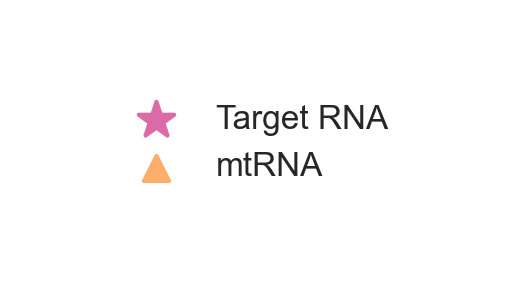

In [31]:
# Plot legend

x = [0, 1]
y = x

fig, ax = plt.subplots(1, 1, figsize=(2,1))

ax.scatter(x, y, 
           marker=gene_to_marker["mCherry"],
           color=gene_to_color["mCherry"],
           zorder=10, s=80,
           label="Target RNA")
ax.scatter(x, y, marker="^", color="#fdae6b", zorder=10, label="mtRNA")

ax.axis('off')
ax.set_xlim(2,3)

fig.legend(loc="center", bbox_to_anchor=(0.5, 0.5), frameon=False)

save_figure(fig, "density_supernatant_vs_cells_legend")

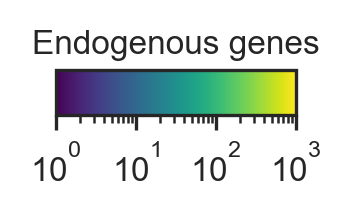

In [32]:
# Plot colorbar

fig, ax = plt.subplots(1, 1, figsize=(1,0.25))

dummy = np.array([[1,100]])  # dummy data
img = plt.imshow(dummy, norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap="viridis")
plt.gca().set_visible(False)  # hide plot
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
cbar = plt.colorbar(orientation="horizontal", cax=cax, label="Endogenous genes", pad=0.1)
cbar.ax.xaxis.set_label_position("top")

save_figure(fig, "density_supernatant_vs_cells_colorbar")